# CSE425 Unsupervised Learning Project: VAE for Hybrid Language Music Clustering

## Project Overview

This notebook implements a complete unsupervised learning pipeline for clustering song lyrics using **Variational Autoencoders (VAE)**. The pipeline processes lyrics from multiple languages and genres, learns meaningful latent representations, and performs clustering analysis.

### Key Components:
1. **Data Loading & Preprocessing** - Clean and prepare lyrics text
2. **Feature Extraction** - TF-IDF (word + char n-grams) with dimensionality reduction
3. **Baseline Clustering** - PCA + KMeans for comparison
4. **VAE Implementation** - PyTorch VAE with KL annealing
5. **Multi-Algorithm Clustering** - KMeans, Agglomerative, DBSCAN on latent space
6. **Comprehensive Evaluation** - Silhouette, CH, DB, ARI, NMI, Purity
7. **Genre & Language Analysis** - Pseudo-label evaluation
8. **Visualization** - t-SNE/UMAP embeddings
9. **Cluster Interpretation** - Keywords and example songs

### Dataset
- **Source**: Scraped Lyrics from 6 Genres (Kaggle)
- **Files**: `lyrics-data.csv`, `artists-data.csv`

---


In [3]:
# =============================================================================
# CELL 1: IMPORTS AND CONFIGURATION
# =============================================================================

import os
import re
import sys
import warnings
import random
from collections import Counter
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    silhouette_score, 
    calinski_harabasz_score, 
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
from sklearn.manifold import TSNE

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("Imports completed successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Imports completed successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


In [4]:
# =============================================================================
# CONFIGURATION PARAMETERS
# =============================================================================

class Config:
    """Central configuration for all hyperparameters and paths."""
    
    # Paths
    INPUT_DIR = "/kaggle/input/scrapped-lyrics-from-6-genres"
    OUTPUT_DIR = "/kaggle/working/cse425_outputs"
    LYRICS_FILE = "lyrics-data.csv"
    ARTISTS_FILE = "artists-data.csv"
    
    # Sampling (set to None for full dataset)
    # Adjust this based on available memory and time constraints
    SAMPLE_SIZE = 40000  # Configurable: 30k-50k recommended for Kaggle
    
    # Text preprocessing
    MIN_LYRIC_LENGTH = 100  # Minimum characters for valid lyrics
    MIN_WORD_COUNT = 20     # Minimum words for valid lyrics
    
    # TF-IDF parameters
    # Word-level: captures semantic meaning through unigrams and bigrams
    # Char-level: captures morphological patterns, handles multilingual text
    TFIDF_MAX_FEATURES_WORD = 5000   # Max word features
    TFIDF_MAX_FEATURES_CHAR = 2000   # Max char n-gram features
    TFIDF_NGRAM_WORD = (1, 2)        # Word unigrams and bigrams
    TFIDF_NGRAM_CHAR = (2, 4)        # Character n-grams (2-4)
    TFIDF_MIN_DF = 5                 # Minimum document frequency
    TFIDF_MAX_DF = 0.95              # Maximum document frequency
    
    # Dimensionality reduction
    SVD_COMPONENTS = 256  # Reduced dimension before VAE
    
    # VAE architecture
    VAE_INPUT_DIM = 256       # Must match SVD_COMPONENTS
    VAE_HIDDEN_DIM = 128      # Hidden layer dimension
    VAE_LATENT_DIM = 32       # Latent space dimension
    VAE_DROPOUT = 0.2         # Dropout rate
    
    # VAE training
    VAE_EPOCHS = 100
    VAE_BATCH_SIZE = 256
    VAE_LEARNING_RATE = 1e-3
    VAE_BETA_START = 0.0      # Initial KL weight (annealing)
    VAE_BETA_END = 1.0        # Final KL weight
    VAE_BETA_WARMUP = 30      # Epochs for KL warmup
    
    # Clustering
    N_CLUSTERS = 8            # Number of clusters for KMeans/Agglomerative
    DBSCAN_EPS = 0.5          # DBSCAN epsilon (will be auto-tuned)
    DBSCAN_MIN_SAMPLES = 10   # DBSCAN minimum samples
    
    # Visualization
    TSNE_PERPLEXITY = 30
    TSNE_N_ITER = 1000
    VIS_SAMPLE_SIZE = 5000    # Sample size for visualization
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create output directory
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
print(f"Configuration loaded successfully!")
print(f"Device: {Config.DEVICE}")
print(f"Output directory: {Config.OUTPUT_DIR}")
print(f"Sample size: {Config.SAMPLE_SIZE}")


Configuration loaded successfully!
Device: cuda
Output directory: /kaggle/working/cse425_outputs
Sample size: 40000


In [5]:
# =============================================================================
# STEP 1: DATA LOADING
# =============================================================================

print("=" * 80)
print("STEP 1: DATA LOADING")
print("=" * 80)

def load_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load lyrics and artists data from CSV files."""
    
    lyrics_path = os.path.join(Config.INPUT_DIR, Config.LYRICS_FILE)
    artists_path = os.path.join(Config.INPUT_DIR, Config.ARTISTS_FILE)
    
    print(f"Loading lyrics from: {lyrics_path}")
    lyrics_df = pd.read_csv(lyrics_path)
    print(f"  → Loaded {len(lyrics_df):,} lyrics records")
    print(f"  → Columns: {list(lyrics_df.columns)}")
    
    print(f"\nLoading artists from: {artists_path}")
    artists_df = pd.read_csv(artists_path)
    print(f"  → Loaded {len(artists_df):,} artists records")
    print(f"  → Columns: {list(artists_df.columns)}")
    
    return lyrics_df, artists_df


lyrics_df, artists_df = load_data()

# Display sample data
print("\nSample lyrics data:")
display(lyrics_df.head(3))
print("\nSample artists data:")
display(artists_df.head(3))

# Basic statistics
print("\nLyrics data info:")
print(f"  Shape: {lyrics_df.shape}")
print(f"  Missing values:")
for col in lyrics_df.columns:
    missing = lyrics_df[col].isna().sum()
    print(f"    {col}: {missing} ({100*missing/len(lyrics_df):.1f}%)")


STEP 1: DATA LOADING
Loading lyrics from: /kaggle/input/scrapped-lyrics-from-6-genres/lyrics-data.csv
  → Loaded 379,931 lyrics records
  → Columns: ['ALink', 'SName', 'SLink', 'Lyric', 'language']

Loading artists from: /kaggle/input/scrapped-lyrics-from-6-genres/artists-data.csv
  → Loaded 4,168 artists records
  → Columns: ['Artist', 'Genres', 'Songs', 'Popularity', 'Link']

Sample lyrics data:


,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt



Sample artists data:


,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/



Lyrics data info:
  Shape: (379931, 5)
  Missing values:
    ALink: 1 (0.0%)
    SName: 3 (0.0%)
    SLink: 1 (0.0%)
    Lyric: 77 (0.0%)
    language: 14635 (3.9%)


STEP 2: TEXT PREPROCESSING
Initial dataset size: 379,931 rows
  After removing empty lyrics: 379,854 (77 removed)
  Cleaning lyrics text...
  After removing short lyrics (< 100 chars): 374,876 (4,978 removed)
  After removing low word count (< 20 words): 374,756 (120 removed)
  After removing duplicate SLinks: 374,733 (23 removed)
  After removing duplicate lyrics: 364,458 (10,275 removed)

Final preprocessed dataset size: 364,458 rows

Language distribution:
language
en         186239
pt         152045
unknown     10440
es           9712
rw           1644
it           1396
fr           1204
de            830
fi            142
sv            109
Name: count, dtype: int64


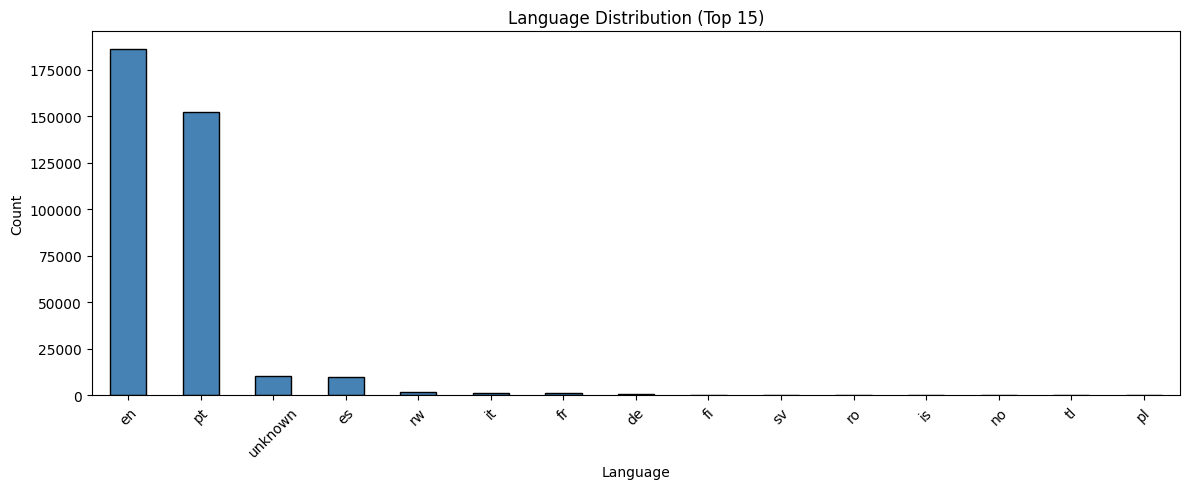


Saved cleaned dataset to: /kaggle/working/cse425_outputs/cleaned_lyrics.csv


In [6]:
# =============================================================================
# STEP 2: TEXT PREPROCESSING
# =============================================================================

print("=" * 80)
print("STEP 2: TEXT PREPROCESSING")
print("=" * 80)

def clean_lyrics(text: str) -> str:
    """
    Thoroughly clean lyrics text by removing:
    - HTML tags
    - URLs
    - Bracketed content (e.g., [Chorus], [Verse 1])
    - Repeated chorus markers
    - Excessive repetition
    - Special characters and noise
    - Multiple whitespaces
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase for consistency
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    
    # Remove bracketed content (section markers like [Chorus], [Verse 1], etc.)
    text = re.sub(r'\[.*?\]', ' ', text)
    text = re.sub(r'\(.*?\)', ' ', text)
    
    # Remove common repeated markers
    text = re.sub(r'\b(chorus|verse|bridge|outro|intro|hook|refrain)\s*\d*\b', ' ', text)
    
    # Remove timestamps
    text = re.sub(r'\d{1,2}:\d{2}(:\d{2})?', ' ', text)
    
    # Remove special characters but keep basic punctuation and letters
    # Keep letters from multiple languages (including accented chars)
    text = re.sub(r'[^\w\s\'\-áéíóúàèìòùâêîôûäëïöüãõñçø]', ' ', text)
    
    # Remove standalone numbers
    text = re.sub(r'\b\d+\b', ' ', text)
    
    # Remove single character words (except 'i' and 'a')
    text = re.sub(r'\b(?![ia])[a-z]\b', ' ', text)
    
    # Remove excessive repetition of words (more than 3 times consecutively)
    text = re.sub(r'\b(\w+)(\s+\1){3,}\b', r'\1 \1 \1', text)
    
    # Remove excessive repetition of characters
    text = re.sub(r'(.)\1{3,}', r'\1\1', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text


def preprocess_lyrics(df: pd.DataFrame) -> pd.DataFrame:
    """Complete preprocessing pipeline for lyrics dataframe."""
    print(f"Initial dataset size: {len(df):,} rows")
    
    # Make a copy
    df = df.copy()
    
    # Step 1: Handle missing lyrics
    df['Lyric'] = df['Lyric'].fillna('')
    initial_count = len(df)
    df = df[df['Lyric'].str.len() > 0]
    print(f"  After removing empty lyrics: {len(df):,} ({initial_count - len(df):,} removed)")
    
    # Step 2: Clean lyrics
    print("  Cleaning lyrics text...")
    df['cleaned_lyric'] = df['Lyric'].apply(clean_lyrics)
    
    # Step 3: Remove short lyrics
    df['lyric_length'] = df['cleaned_lyric'].str.len()
    df['word_count'] = df['cleaned_lyric'].str.split().str.len()
    
    before = len(df)
    df = df[df['lyric_length'] >= Config.MIN_LYRIC_LENGTH]
    print(f"  After removing short lyrics (< {Config.MIN_LYRIC_LENGTH} chars): {len(df):,} ({before - len(df):,} removed)")
    
    before = len(df)
    df = df[df['word_count'] >= Config.MIN_WORD_COUNT]
    print(f"  After removing low word count (< {Config.MIN_WORD_COUNT} words): {len(df):,} ({before - len(df):,} removed)")
    
    # Step 4: Remove duplicates by SLink
    before = len(df)
    df = df.drop_duplicates(subset=['SLink'], keep='first')
    print(f"  After removing duplicate SLinks: {len(df):,} ({before - len(df):,} removed)")
    
    # Step 5: Remove duplicates by cleaned lyrics (near-duplicates)
    before = len(df)
    df = df.drop_duplicates(subset=['cleaned_lyric'], keep='first')
    print(f"  After removing duplicate lyrics: {len(df):,} ({before - len(df):,} removed)")
    
    # Step 6: Handle missing language
    df['language'] = df['language'].fillna('unknown')
    
    # Step 7: Reset index
    df = df.reset_index(drop=True)
    
    print(f"\nFinal preprocessed dataset size: {len(df):,} rows")
    
    return df


# Preprocess lyrics
lyrics_clean = preprocess_lyrics(lyrics_df)

# Language distribution
print("\nLanguage distribution:")
lang_dist = lyrics_clean['language'].value_counts()
print(lang_dist.head(10))

# Visualize language distribution
plt.figure(figsize=(12, 5))
lang_dist.head(15).plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Language Distribution (Top 15)')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save cleaned dataset
cleaned_path = os.path.join(Config.OUTPUT_DIR, "cleaned_lyrics.csv")
lyrics_clean.to_csv(cleaned_path, index=False)
print(f"\nSaved cleaned dataset to: {cleaned_path}")


In [7]:
# =============================================================================
# STEP 3: SAMPLING (IF NEEDED FOR COMPUTATIONAL EFFICIENCY)
# =============================================================================

print("=" * 80)
print("STEP 3: SAMPLING")
print("=" * 80)

def sample_data(df: pd.DataFrame, sample_size: Optional[int] = None) -> pd.DataFrame:
    """
    Sample data if needed for computational efficiency.
    Uses stratified sampling by language when possible.
    """
    if sample_size is None or sample_size >= len(df):
        print(f"Using full dataset: {len(df):,} rows")
        return df
    
    print(f"Sampling {sample_size:,} rows from {len(df):,} total rows")
    
    # Try stratified sampling by language
    try:
        # Calculate proportional sample sizes per language
        lang_counts = df['language'].value_counts()
        sample_fracs = sample_size / len(df)
        
        sampled_dfs = []
        remaining = sample_size
        
        for lang in lang_counts.index:
            lang_df = df[df['language'] == lang]
            n_sample = min(int(len(lang_df) * sample_fracs * 1.1), len(lang_df), remaining)
            if n_sample > 0:
                sampled_dfs.append(lang_df.sample(n=n_sample, random_state=RANDOM_SEED))
                remaining -= n_sample
            if remaining <= 0:
                break
        
        sampled_df = pd.concat(sampled_dfs, ignore_index=True)
        
        # If we need more samples, add randomly
        if len(sampled_df) < sample_size:
            remaining_df = df[~df.index.isin(sampled_df.index)]
            additional = remaining_df.sample(
                n=min(sample_size - len(sampled_df), len(remaining_df)),
                random_state=RANDOM_SEED
            )
            sampled_df = pd.concat([sampled_df, additional], ignore_index=True)
        
        # Trim if we have too many
        if len(sampled_df) > sample_size:
            sampled_df = sampled_df.sample(n=sample_size, random_state=RANDOM_SEED)
        
        sampled_df = sampled_df.reset_index(drop=True)
        print(f"Sampled dataset size: {len(sampled_df):,} rows")
        
    except Exception as e:
        print(f"Stratified sampling failed, using random sampling: {e}")
        sampled_df = df.sample(n=sample_size, random_state=RANDOM_SEED).reset_index(drop=True)
    
    return sampled_df


# Sample data
lyrics_sampled = sample_data(lyrics_clean, Config.SAMPLE_SIZE)

# Save sampled dataset
sampled_path = os.path.join(Config.OUTPUT_DIR, "sampled_lyrics.csv")
lyrics_sampled.to_csv(sampled_path, index=False)
print(f"Saved sampled dataset to: {sampled_path}")

# Show sampled language distribution
print("\nSampled language distribution:")
print(lyrics_sampled['language'].value_counts().head(10))


STEP 3: SAMPLING
Sampling 40,000 rows from 364,458 total rows
Sampled dataset size: 40,000 rows
Saved sampled dataset to: /kaggle/working/cse425_outputs/sampled_lyrics.csv

Sampled language distribution:
language
en    22484
pt    17516
Name: count, dtype: int64


STEP 4: FEATURE EXTRACTION
Extracting TF-IDF features...
  Word TF-IDF: max_features=5000, ngram=(1, 2)
    → Word features shape: (40000, 5000)
  Char TF-IDF: max_features=2000, ngram=(2, 4)
    → Char features shape: (40000, 2000)
  Combined features shape: (40000, 7000)
  Applying TruncatedSVD: 7000 → 256 dimensions
    → Explained variance: 44.72%
  Standardizing features...
    → Final features shape: (40000, 256)

Feature extraction complete!
  Input: 40,000 lyrics
  Output: (40000, 256) feature matrix


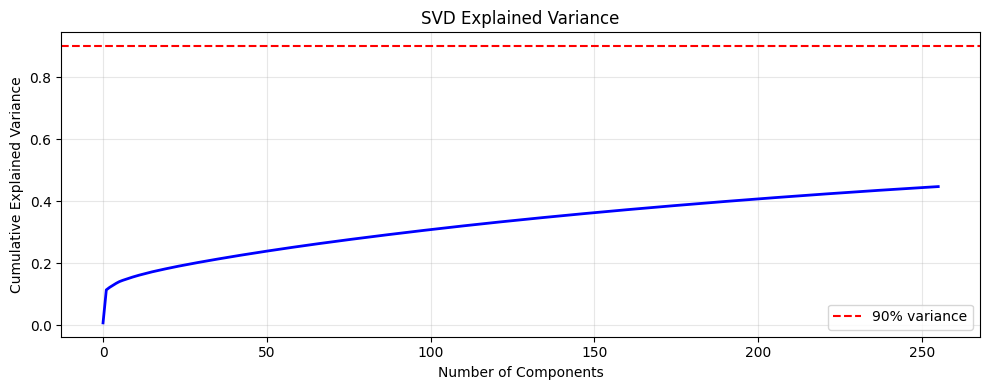

In [8]:
# =============================================================================
# STEP 4: FEATURE EXTRACTION (TF-IDF + DIMENSIONALITY REDUCTION)
# =============================================================================

print("=" * 80)
print("STEP 4: FEATURE EXTRACTION")
print("=" * 80)

def extract_features(texts: List[str]) -> Tuple[np.ndarray, TfidfVectorizer, TfidfVectorizer, TruncatedSVD, StandardScaler]:
    """
    Extract features using TF-IDF (word + char n-grams) and reduce dimensionality.
    
    The approach combines:
    1. Word-level TF-IDF: Captures semantic meaning through unigrams and bigrams
    2. Character-level TF-IDF: Captures morphological patterns and handles 
       multilingual text (important for hybrid language analysis)
    3. TruncatedSVD: Reduces dimensionality while preserving variance
    4. StandardScaler: Normalizes features for VAE training
    """
    
    print("Extracting TF-IDF features...")
    
    # Word-level TF-IDF
    # - ngram_range=(1,2): Captures both individual words and common phrases
    # - max_features: Limits vocabulary to most informative terms
    # - min_df/max_df: Removes rare and overly common terms
    # - sublinear_tf: Applies log scaling to reduce impact of high-frequency words
    print(f"  Word TF-IDF: max_features={Config.TFIDF_MAX_FEATURES_WORD}, ngram={Config.TFIDF_NGRAM_WORD}")
    tfidf_word = TfidfVectorizer(
        max_features=Config.TFIDF_MAX_FEATURES_WORD,
        ngram_range=Config.TFIDF_NGRAM_WORD,
        min_df=Config.TFIDF_MIN_DF,
        max_df=Config.TFIDF_MAX_DF,
        sublinear_tf=True,
        strip_accents=None,  # Keep accents for multilingual support
        lowercase=True
    )
    tfidf_word_features = tfidf_word.fit_transform(texts)
    print(f"    → Word features shape: {tfidf_word_features.shape}")
    
    # Character-level TF-IDF
    # - analyzer='char_wb': Character n-grams within word boundaries
    # - Captures patterns across languages (e.g., Spanish suffixes, Portuguese patterns)
    # - More robust to typos and spelling variations
    print(f"  Char TF-IDF: max_features={Config.TFIDF_MAX_FEATURES_CHAR}, ngram={Config.TFIDF_NGRAM_CHAR}")
    tfidf_char = TfidfVectorizer(
        analyzer='char_wb',
        max_features=Config.TFIDF_MAX_FEATURES_CHAR,
        ngram_range=Config.TFIDF_NGRAM_CHAR,
        min_df=Config.TFIDF_MIN_DF,
        max_df=Config.TFIDF_MAX_DF,
        sublinear_tf=True
    )
    tfidf_char_features = tfidf_char.fit_transform(texts)
    print(f"    → Char features shape: {tfidf_char_features.shape}")
    
    # Combine word and character features
    from scipy.sparse import hstack
    combined_features = hstack([tfidf_word_features, tfidf_char_features])
    print(f"  Combined features shape: {combined_features.shape}")
    
    # Dimensionality reduction with TruncatedSVD
    # - TruncatedSVD works efficiently with sparse matrices (unlike PCA)
    # - Reduces to manageable dimension for VAE input
    # - Preserves most variance while reducing noise
    print(f"  Applying TruncatedSVD: {combined_features.shape[1]} → {Config.SVD_COMPONENTS} dimensions")
    svd = TruncatedSVD(n_components=Config.SVD_COMPONENTS, random_state=RANDOM_SEED)
    reduced_features = svd.fit_transform(combined_features)
    explained_var = svd.explained_variance_ratio_.sum()
    print(f"    → Explained variance: {explained_var:.2%}")
    
    # Standardize features for VAE training
    # - Zero mean, unit variance
    # - Important for stable VAE training
    print("  Standardizing features...")
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(reduced_features)
    print(f"    → Final features shape: {normalized_features.shape}")
    
    return normalized_features, tfidf_word, tfidf_char, svd, scaler


# Extract features
texts = lyrics_sampled['cleaned_lyric'].tolist()
features, tfidf_word, tfidf_char, svd, scaler = extract_features(texts)

print(f"\nFeature extraction complete!")
print(f"  Input: {len(texts):,} lyrics")
print(f"  Output: {features.shape} feature matrix")

# Visualize explained variance by SVD components
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(svd.explained_variance_ratio_), 'b-', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('SVD Explained Variance')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% variance')
plt.legend()
plt.tight_layout()
plt.show()


STEP 5: BASELINE CLUSTERING (PCA + KMeans)
Running baseline: PCA + KMeans (k=8)
  PCA explained variance: 19.97%

  Baseline Results:
    Silhouette Score: 0.0035
    Calinski-Harabasz Index: 526.46
    Davies-Bouldin Index: 5.2291

Saved baseline metrics to: /kaggle/working/cse425_outputs/baseline_metrics.csv


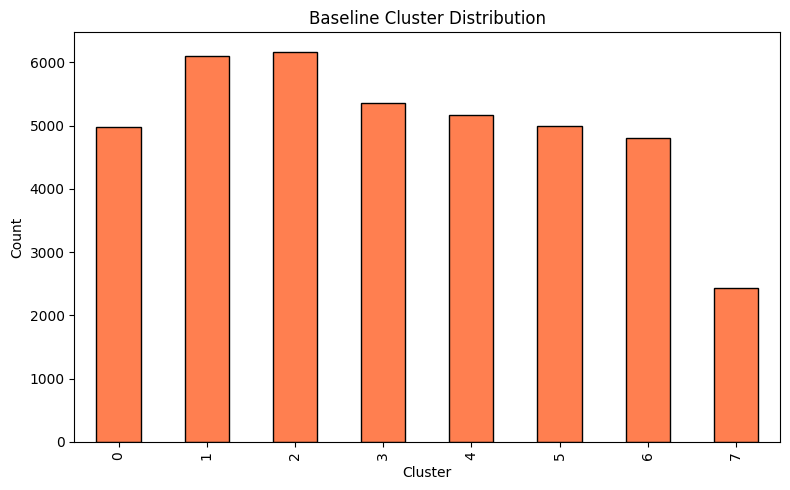

In [9]:
# =============================================================================
# STEP 5: BASELINE CLUSTERING (PCA + KMeans)
# =============================================================================

print("=" * 80)
print("STEP 5: BASELINE CLUSTERING (PCA + KMeans)")
print("=" * 80)

def compute_clustering_metrics(X: np.ndarray, labels: np.ndarray) -> Dict[str, float]:
    """Compute all clustering evaluation metrics."""
    
    # Filter out noise points (label = -1) for DBSCAN
    valid_mask = labels >= 0
    n_clusters = len(set(labels[valid_mask]))
    
    if n_clusters < 2:
        return {
            'silhouette': np.nan,
            'calinski_harabasz': np.nan,
            'davies_bouldin': np.nan,
            'n_clusters': n_clusters
        }
    
    X_valid = X[valid_mask]
    labels_valid = labels[valid_mask]
    
    metrics = {
        'silhouette': silhouette_score(X_valid, labels_valid),
        'calinski_harabasz': calinski_harabasz_score(X_valid, labels_valid),
        'davies_bouldin': davies_bouldin_score(X_valid, labels_valid),
        'n_clusters': n_clusters
    }
    
    return metrics


def run_baseline_clustering(X: np.ndarray, n_clusters: int) -> Tuple[np.ndarray, Dict]:
    """
    Baseline: PCA dimensionality reduction + KMeans clustering.
    This provides a comparison point for VAE-based clustering.
    """
    print(f"Running baseline: PCA + KMeans (k={n_clusters})")
    
    # Apply PCA for comparison
    pca = PCA(n_components=min(50, X.shape[1]), random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(X)
    print(f"  PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
    
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_pca)
    
    # Compute metrics
    metrics = compute_clustering_metrics(X_pca, labels)
    metrics['method'] = 'PCA_KMeans_Baseline'
    
    print(f"\n  Baseline Results:")
    print(f"    Silhouette Score: {metrics['silhouette']:.4f}")
    print(f"    Calinski-Harabasz Index: {metrics['calinski_harabasz']:.2f}")
    print(f"    Davies-Bouldin Index: {metrics['davies_bouldin']:.4f}")
    
    return labels, metrics


# Run baseline
baseline_labels, baseline_metrics = run_baseline_clustering(features, Config.N_CLUSTERS)

# Save baseline metrics
baseline_df = pd.DataFrame([baseline_metrics])
baseline_path = os.path.join(Config.OUTPUT_DIR, "baseline_metrics.csv")
baseline_df.to_csv(baseline_path, index=False)
print(f"\nSaved baseline metrics to: {baseline_path}")

# Visualize baseline cluster distribution
plt.figure(figsize=(8, 5))
pd.Series(baseline_labels).value_counts().sort_index().plot(kind='bar', color='coral', edgecolor='black')
plt.title('Baseline Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [10]:
# =============================================================================
# STEP 6: VAE IMPLEMENTATION
# =============================================================================

print("=" * 80)
print("STEP 6: VAE IMPLEMENTATION")
print("=" * 80)

class VAE(nn.Module):
    """
    Variational Autoencoder for learning latent representations of lyrics.
    
    Architecture:
    - Encoder: Input → Hidden → (mu, log_var)
    - Reparameterization: z = mu + std * epsilon
    - Decoder: z → Hidden → Reconstruction
    
    Training tricks to avoid posterior collapse:
    - KL Annealing (beta warmup): Gradually increase KL weight
    - Dropout: Regularization in encoder/decoder
    - Batch normalization: Stable training
    - Gradient clipping: Prevent exploding gradients
    """
    
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int, dropout: float = 0.2):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout)
        )
        
        # Latent space parameters (mean and log variance)
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        
        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Encode input to latent distribution parameters."""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick: z = mu + std * epsilon
        This allows gradients to flow through the sampling process.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent vector to reconstruction."""
        return self.decoder(z)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass: encode → reparameterize → decode."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar
    
    def get_latent(self, x: torch.Tensor) -> torch.Tensor:
        """Extract latent vectors (mean) for clustering."""
        mu, _ = self.encode(x)
        return mu


def vae_loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, 
             logvar: torch.Tensor, beta: float = 1.0) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    VAE loss = Reconstruction Loss + β * KL Divergence
    
    - Reconstruction loss: MSE (since features are continuous)
    - KL divergence: Regularizes latent space to be close to N(0,1)
    - β: Controls the weight of KL term (for KL annealing / β-VAE)
    """
    # Reconstruction loss (Mean Squared Error)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    
    # KL divergence: D_KL(q(z|x) || p(z))
    # Closed-form for Gaussian: -0.5 * sum(1 + log(σ²) - μ² - σ²)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss with β weighting
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss


# Initialize VAE
vae_model = VAE(
    input_dim=Config.VAE_INPUT_DIM,
    hidden_dim=Config.VAE_HIDDEN_DIM,
    latent_dim=Config.VAE_LATENT_DIM,
    dropout=Config.VAE_DROPOUT
)

print("VAE Architecture:")
print(vae_model)
print(f"\nTotal parameters: {sum(p.numel() for p in vae_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in vae_model.parameters() if p.requires_grad):,}")


STEP 6: VAE IMPLEMENTATION
VAE Architecture:
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.2, inplace=False)
  )
  (fc_mu): Linear(in_features=64, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): BatchNorm1d(1

In [12]:
# =============================================================================
# STEP 7: VAE TRAINING
# =============================================================================

print("=" * 80)
print("STEP 7: VAE TRAINING")
print("=" * 80)

def train_vae(model: VAE, train_loader: DataLoader, config: Config) -> List[Dict]:
    """
    Train VAE with KL annealing to prevent posterior collapse.
    
    KL Annealing: Gradually increases the weight of KL divergence loss.
    This allows the model to first learn good reconstructions, then
    gradually regularize the latent space.
    """
    model.to(config.DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=config.VAE_LEARNING_RATE)
    
    # Learning rate scheduler - reduce LR on plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )
    
    training_history = []
    
    print(f"\nTraining VAE for {config.VAE_EPOCHS} epochs...")
    print(f"  Device: {config.DEVICE}")
    print(f"  Batch size: {config.VAE_BATCH_SIZE}")
    print(f"  KL annealing: β from {config.VAE_BETA_START} to {config.VAE_BETA_END} over {config.VAE_BETA_WARMUP} epochs")
    print("-" * 60)
    
    for epoch in range(config.VAE_EPOCHS):
        model.train()
        total_loss = 0
        total_recon = 0
        total_kl = 0
        n_batches = 0
        
        # KL annealing: gradually increase β from 0 to 1
        if epoch < config.VAE_BETA_WARMUP:
            beta = config.VAE_BETA_START + (config.VAE_BETA_END - config.VAE_BETA_START) * (epoch / config.VAE_BETA_WARMUP)
        else:
            beta = config.VAE_BETA_END
        
        for batch_idx, (data,) in enumerate(train_loader):
            data = data.to(config.DEVICE)
            
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon, data, mu, logvar, beta)
            
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            n_batches += 1
        
        avg_loss = total_loss / n_batches
        avg_recon = total_recon / n_batches
        avg_kl = total_kl / n_batches
        
        scheduler.step(avg_loss)
        
        training_history.append({
            'epoch': epoch + 1,
            'total_loss': avg_loss,
            'recon_loss': avg_recon,
            'kl_loss': avg_kl,
            'beta': beta,
            'lr': optimizer.param_groups[0]['lr']
        })
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1:3d}/{config.VAE_EPOCHS}: "
                  f"Loss={avg_loss:.4f} (Recon={avg_recon:.4f}, KL={avg_kl:.4f}), β={beta:.3f}")
    
    print("-" * 60)
    print("Training complete!")
    return training_history


# Prepare data for VAE
print("Preparing data for VAE training...")
X_tensor = torch.FloatTensor(features)
train_dataset = TensorDataset(X_tensor)
train_loader = DataLoader(train_dataset, batch_size=Config.VAE_BATCH_SIZE, shuffle=True)

# Train VAE
training_history = train_vae(vae_model, train_loader, Config)

# Save training history
history_df = pd.DataFrame(training_history)
history_path = os.path.join(Config.OUTPUT_DIR, "training_history.csv")
history_df.to_csv(history_path, index=False)
print(f"\nSaved training history to: {history_path}")

# Save model checkpoint
model_path = os.path.join(Config.OUTPUT_DIR, "vae_model.pt")
torch.save({
    'model_state_dict': vae_model.state_dict(),
    'config': {
        'input_dim': Config.VAE_INPUT_DIM,
        'hidden_dim': Config.VAE_HIDDEN_DIM,
        'latent_dim': Config.VAE_LATENT_DIM,
        'dropout': Config.VAE_DROPOUT
    }
}, model_path)
print(f"Saved model checkpoint to: {model_path}")


STEP 7: VAE TRAINING
Preparing data for VAE training...

Training VAE for 100 epochs...
  Device: cuda
  Batch size: 256
  KL annealing: β from 0.0 to 1.0 over 30 epochs
------------------------------------------------------------
  Epoch   1/100: Loss=1.0287 (Recon=1.0287, KL=0.4561), β=0.000
  Epoch  10/100: Loss=1.0004 (Recon=0.9883, KL=0.0403), β=0.300
  Epoch  20/100: Loss=1.0012 (Recon=0.9985, KL=0.0042), β=0.633
  Epoch  30/100: Loss=1.0001 (Recon=1.0001, KL=0.0000), β=0.967
  Epoch  40/100: Loss=1.0003 (Recon=1.0003, KL=0.0000), β=1.000
  Epoch  50/100: Loss=1.0002 (Recon=1.0002, KL=0.0000), β=1.000
  Epoch  60/100: Loss=1.0002 (Recon=1.0002, KL=0.0000), β=1.000
  Epoch  70/100: Loss=1.0001 (Recon=1.0001, KL=0.0000), β=1.000
  Epoch  80/100: Loss=1.0002 (Recon=1.0002, KL=0.0000), β=1.000
  Epoch  90/100: Loss=1.0000 (Recon=1.0000, KL=0.0000), β=1.000
  Epoch 100/100: Loss=1.0001 (Recon=1.0001, KL=0.0000), β=1.000
------------------------------------------------------------
Trai

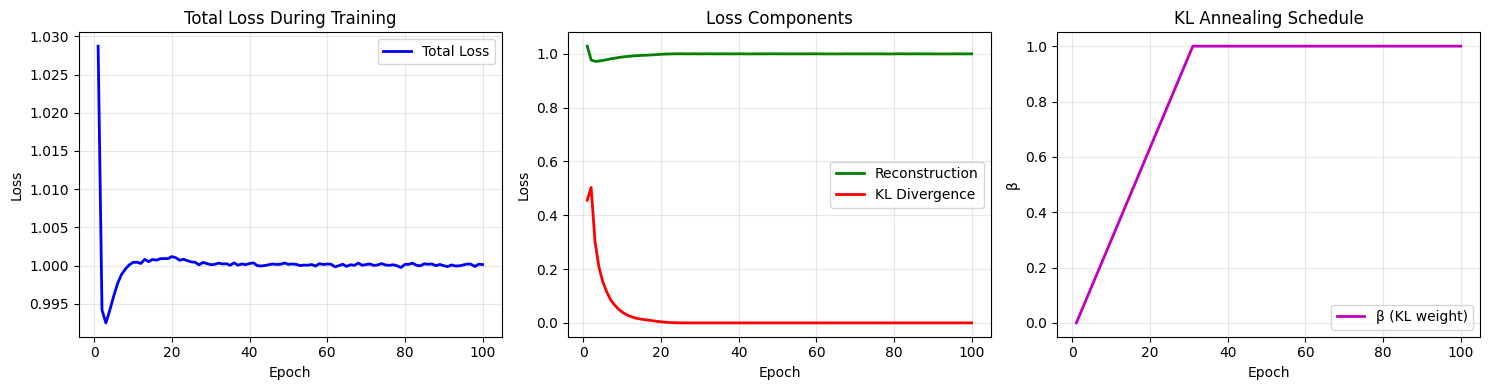

Saved training curve to: /kaggle/working/cse425_outputs/training_curve.png


In [13]:
# =============================================================================
# VISUALIZE TRAINING CURVES
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total loss
axes[0].plot(history_df['epoch'], history_df['total_loss'], 'b-', linewidth=2, label='Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total Loss During Training')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss components
axes[1].plot(history_df['epoch'], history_df['recon_loss'], 'g-', linewidth=2, label='Reconstruction')
axes[1].plot(history_df['epoch'], history_df['kl_loss'], 'r-', linewidth=2, label='KL Divergence')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# KL annealing schedule
axes[2].plot(history_df['epoch'], history_df['beta'], 'm-', linewidth=2, label='β (KL weight)')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('β')
axes[2].set_title('KL Annealing Schedule')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
training_curve_path = os.path.join(Config.OUTPUT_DIR, "training_curve.png")
plt.savefig(training_curve_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved training curve to: {training_curve_path}")


STEP 8: EXTRACT LATENT VECTORS
Extracted latent vectors: (40000, 32)
  Latent dimension: 32
  Number of samples: 40000
Saved latent vectors to: /kaggle/working/cse425_outputs/latent_vectors.npy


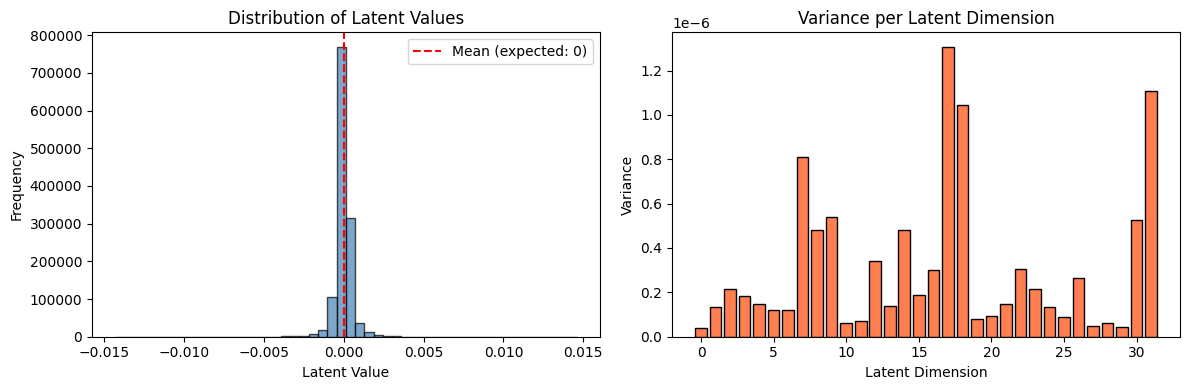

In [14]:
# =============================================================================
# STEP 8: EXTRACT LATENT VECTORS
# =============================================================================

print("=" * 80)
print("STEP 8: EXTRACT LATENT VECTORS")
print("=" * 80)

def extract_latent_vectors(model: VAE, data_loader: DataLoader, device: torch.device) -> np.ndarray:
    """Extract latent vectors (mu) from trained VAE for clustering."""
    model.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for (batch,) in data_loader:
            batch = batch.to(device)
            mu, _ = model.encode(batch)
            latent_vectors.append(mu.cpu().numpy())
    
    return np.vstack(latent_vectors)


# Extract latent vectors
eval_loader = DataLoader(train_dataset, batch_size=Config.VAE_BATCH_SIZE, shuffle=False)
latent_Z = extract_latent_vectors(vae_model, eval_loader, Config.DEVICE)

print(f"Extracted latent vectors: {latent_Z.shape}")
print(f"  Latent dimension: {latent_Z.shape[1]}")
print(f"  Number of samples: {latent_Z.shape[0]}")

# Save latent vectors
latent_path = os.path.join(Config.OUTPUT_DIR, "latent_vectors.npy")
np.save(latent_path, latent_Z)
print(f"Saved latent vectors to: {latent_path}")

# Visualize latent space statistics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution of latent values
axes[0].hist(latent_Z.flatten(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Latent Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Latent Values')
axes[0].axvline(x=0, color='r', linestyle='--', label='Mean (expected: 0)')
axes[0].legend()

# Variance per latent dimension
latent_vars = np.var(latent_Z, axis=0)
axes[1].bar(range(len(latent_vars)), latent_vars, color='coral', edgecolor='black')
axes[1].set_xlabel('Latent Dimension')
axes[1].set_ylabel('Variance')
axes[1].set_title('Variance per Latent Dimension')

plt.tight_layout()
plt.show()


In [15]:
# =============================================================================
# STEP 9: CLUSTERING ON LATENT SPACE
# =============================================================================

print("=" * 80)
print("STEP 9: CLUSTERING ON LATENT SPACE")
print("=" * 80)

def run_all_clustering(Z: np.ndarray, n_clusters: int) -> Dict[str, Tuple[np.ndarray, Dict]]:
    """
    Run multiple clustering algorithms on latent space.
    """
    results = {}
    
    # 1. KMeans
    print("\n1. KMeans Clustering")
    print("-" * 40)
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED, n_init=10, max_iter=300)
    kmeans_labels = kmeans.fit_predict(Z)
    kmeans_metrics = compute_clustering_metrics(Z, kmeans_labels)
    kmeans_metrics['method'] = 'VAE_KMeans'
    results['kmeans'] = (kmeans_labels, kmeans_metrics)
    print(f"   Silhouette: {kmeans_metrics['silhouette']:.4f}")
    print(f"   Calinski-Harabasz: {kmeans_metrics['calinski_harabasz']:.2f}")
    print(f"   Davies-Bouldin: {kmeans_metrics['davies_bouldin']:.4f}")
    
    # 2. Agglomerative Clustering
    print("\n2. Agglomerative Clustering (Ward linkage)")
    print("-" * 40)
    agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agglo_labels = agglo.fit_predict(Z)
    agglo_metrics = compute_clustering_metrics(Z, agglo_labels)
    agglo_metrics['method'] = 'VAE_Agglomerative'
    results['agglomerative'] = (agglo_labels, agglo_metrics)
    print(f"   Silhouette: {agglo_metrics['silhouette']:.4f}")
    print(f"   Calinski-Harabasz: {agglo_metrics['calinski_harabasz']:.2f}")
    print(f"   Davies-Bouldin: {agglo_metrics['davies_bouldin']:.4f}")
    
    # 3. DBSCAN with adaptive eps
    print("\n3. DBSCAN Clustering (adaptive eps)")
    print("-" * 40)
    # Use k-nearest neighbors to find appropriate eps
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=Config.DBSCAN_MIN_SAMPLES)
    nn.fit(Z)
    distances, _ = nn.kneighbors(Z)
    distances = np.sort(distances[:, -1])
    eps = np.percentile(distances, 90)  # 90th percentile as eps
    
    dbscan = DBSCAN(eps=eps, min_samples=Config.DBSCAN_MIN_SAMPLES)
    dbscan_labels = dbscan.fit_predict(Z)
    dbscan_metrics = compute_clustering_metrics(Z, dbscan_labels)
    dbscan_metrics['method'] = 'VAE_DBSCAN'
    dbscan_metrics['eps'] = eps
    dbscan_metrics['n_noise'] = np.sum(dbscan_labels == -1)
    results['dbscan'] = (dbscan_labels, dbscan_metrics)
    print(f"   Eps (adaptive): {eps:.4f}")
    print(f"   N clusters: {dbscan_metrics['n_clusters']}")
    print(f"   N noise points: {dbscan_metrics['n_noise']} ({100*dbscan_metrics['n_noise']/len(Z):.1f}%)")
    if not np.isnan(dbscan_metrics['silhouette']):
        print(f"   Silhouette: {dbscan_metrics['silhouette']:.4f}")
        print(f"   Calinski-Harabasz: {dbscan_metrics['calinski_harabasz']:.2f}")
        print(f"   Davies-Bouldin: {dbscan_metrics['davies_bouldin']:.4f}")
    
    # Try HDBSCAN if available
    try:
        import hdbscan
        print("\n4. HDBSCAN Clustering")
        print("-" * 40)
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=Config.DBSCAN_MIN_SAMPLES * 2, 
            min_samples=Config.DBSCAN_MIN_SAMPLES
        )
        hdbscan_labels = clusterer.fit_predict(Z)
        hdbscan_metrics = compute_clustering_metrics(Z, hdbscan_labels)
        hdbscan_metrics['method'] = 'VAE_HDBSCAN'
        hdbscan_metrics['n_noise'] = np.sum(hdbscan_labels == -1)
        results['hdbscan'] = (hdbscan_labels, hdbscan_metrics)
        print(f"   N clusters: {hdbscan_metrics['n_clusters']}")
        print(f"   N noise points: {hdbscan_metrics['n_noise']} ({100*hdbscan_metrics['n_noise']/len(Z):.1f}%)")
        if not np.isnan(hdbscan_metrics['silhouette']):
            print(f"   Silhouette: {hdbscan_metrics['silhouette']:.4f}")
    except ImportError:
        print("\n4. HDBSCAN not available, skipping...")
    
    return results


# Run clustering
clustering_results = run_all_clustering(latent_Z, Config.N_CLUSTERS)

# Compile metrics
all_metrics = [baseline_metrics]
for method, (labels, metrics) in clustering_results.items():
    all_metrics.append(metrics)

metrics_df = pd.DataFrame(all_metrics)
metrics_path = os.path.join(Config.OUTPUT_DIR, "clustering_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print(f"\nSaved clustering metrics to: {metrics_path}")

print("\n" + "=" * 60)
print("CLUSTERING METRICS SUMMARY")
print("=" * 60)
display(metrics_df)

# Use KMeans labels as primary clustering
primary_labels = clustering_results['kmeans'][0]


STEP 9: CLUSTERING ON LATENT SPACE

1. KMeans Clustering
----------------------------------------
   Silhouette: 0.2103
   Calinski-Harabasz: 12205.73
   Davies-Bouldin: 1.2035

2. Agglomerative Clustering (Ward linkage)
----------------------------------------
   Silhouette: 0.1835
   Calinski-Harabasz: 10264.45
   Davies-Bouldin: 1.4475

3. DBSCAN Clustering (adaptive eps)
----------------------------------------
   Eps (adaptive): 0.0012
   N clusters: 2
   N noise points: 2567 (6.4%)
   Silhouette: 0.6057
   Calinski-Harabasz: 85.80
   Davies-Bouldin: 0.4095

4. HDBSCAN Clustering
----------------------------------------
   N clusters: 2
   N noise points: 17697 (44.2%)
   Silhouette: 0.7134

Saved clustering metrics to: /kaggle/working/cse425_outputs/clustering_metrics.csv

CLUSTERING METRICS SUMMARY


,silhouette,calinski_harabasz,davies_bouldin,n_clusters,method,eps,n_noise
0,0.003542,526.456780,5.229126,8,PCA_KMeans_Baseline,NaN,NaN
1,0.210300,12205.725586,1.203471,8,VAE_KMeans,NaN,NaN
2,0.183548,10264.454102,1.447465,8,VAE_Agglomerative,NaN,NaN
3,0.605722,85.796326,0.409457,2,VAE_DBSCAN,0.001201,2567.0
4,0.713364,11247.227539,0.459030,2,VAE_HDBSCAN,NaN,17697.0


STEP 10: GENRE MAPPING AND PSEUDO-LABEL EVALUATION
Joining lyrics with artists data...
  Merged dataset: 40000 rows
  Rows with genre info: 39914 (99.8%)

Macro genre distribution:
macro_genre
rock               11474
brazilian           7080
other               6333
hiphop              3705
pop                 3377
metal               2663
jazz_blues_soul     2107
country_folk        2066
electronic           588
reggae               521
unknown               86
Name: count, dtype: int64


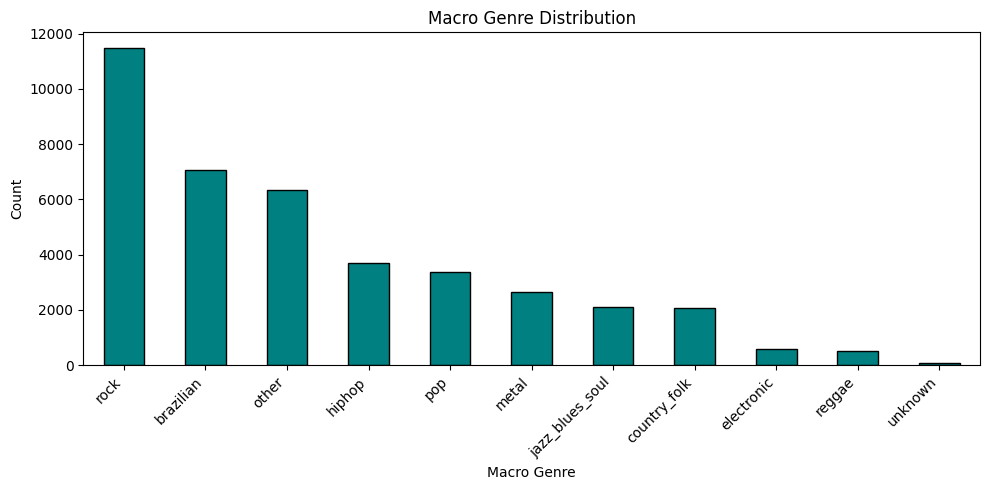

In [16]:
# =============================================================================
# STEP 10: GENRE MAPPING AND PSEUDO-LABEL EVALUATION
# =============================================================================

print("=" * 80)
print("STEP 10: GENRE MAPPING AND PSEUDO-LABEL EVALUATION")
print("=" * 80)

def map_to_macro_genre(genres_str: str) -> str:
    """
    Map detailed genres to macro genres (6-10 categories).
    This simplifies the genre space for more meaningful clustering analysis.
    """
    if not isinstance(genres_str, str):
        return 'unknown'
    
    genres_lower = genres_str.lower()
    
    # Define macro genre mappings (order matters - first match wins)
    mappings = [
        (['hip hop', 'rap', 'trap', 'drill', 'grime'], 'hiphop'),
        (['metal', 'death metal', 'black metal', 'heavy metal', 'thrash'], 'metal'),
        (['rock', 'punk', 'grunge', 'alternative', 'indie rock', 'hard rock'], 'rock'),
        (['pop', 'dance pop', 'synth pop', 'electropop', 'k-pop', 'j-pop'], 'pop'),
        (['electronic', 'edm', 'house', 'techno', 'trance', 'dubstep', 'electro'], 'electronic'),
        (['country', 'folk', 'americana', 'bluegrass'], 'country_folk'),
        (['jazz', 'blues', 'soul', 'r&b', 'rnb', 'funk', 'motown'], 'jazz_blues_soul'),
        (['reggae', 'ska', 'dancehall', 'dub'], 'reggae'),
        (['latin', 'reggaeton', 'salsa', 'bachata', 'cumbia', 'merengue', 'latin pop'], 'latin'),
        (['sertanejo', 'mpb', 'bossa nova', 'forró', 'pagode', 'axé', 'brazilian'], 'brazilian'),
        (['classical', 'orchestra', 'opera'], 'classical'),
    ]
    
    for keywords, macro in mappings:
        if any(kw in genres_lower for kw in keywords):
            return macro
    
    return 'other'


def prepare_pseudo_labels(lyrics_df: pd.DataFrame, artists_df: pd.DataFrame) -> pd.DataFrame:
    """
    Join lyrics with artists data and create pseudo-labels from genres.
    """
    print("Joining lyrics with artists data...")
    
    # Merge on ALink = Link
    merged = lyrics_df.merge(
        artists_df[['Link', 'Genres', 'Popularity']],
        left_on='ALink',
        right_on='Link',
        how='left'
    )
    
    print(f"  Merged dataset: {len(merged)} rows")
    print(f"  Rows with genre info: {merged['Genres'].notna().sum()} ({100*merged['Genres'].notna().mean():.1f}%)")
    
    # Map to macro genres
    merged['macro_genre'] = merged['Genres'].apply(map_to_macro_genre)
    
    print("\nMacro genre distribution:")
    genre_dist = merged['macro_genre'].value_counts()
    print(genre_dist)
    
    return merged


def compute_cluster_purity(labels: np.ndarray, true_labels: np.ndarray) -> float:
    """
    Compute cluster purity: proportion of correctly clustered samples.
    Purity = (1/N) * Σ max_j |cluster_i ∩ class_j|
    """
    contingency = pd.crosstab(labels, true_labels)
    return contingency.max(axis=1).sum() / len(labels)


def evaluate_with_pseudo_labels(
    cluster_labels: np.ndarray,
    true_labels: np.ndarray,
    method_name: str
) -> Dict[str, float]:
    """
    Evaluate clustering using pseudo-labels (genres).
    Computes ARI, NMI, and Purity.
    """
    # Filter valid labels
    valid_mask = (cluster_labels >= 0) & (true_labels != 'unknown')
    
    if valid_mask.sum() < 100:
        print(f"  Warning: Only {valid_mask.sum()} valid samples for evaluation")
        return {'method': method_name, 'ari': np.nan, 'nmi': np.nan, 'purity': np.nan}
    
    cluster_valid = cluster_labels[valid_mask]
    true_valid = true_labels[valid_mask]
    
    # Encode string labels
    le = LabelEncoder()
    true_encoded = le.fit_transform(true_valid)
    
    # Compute metrics
    ari = adjusted_rand_score(true_encoded, cluster_valid)
    nmi = normalized_mutual_info_score(true_encoded, cluster_valid)
    purity = compute_cluster_purity(cluster_valid, true_encoded)
    
    return {
        'method': method_name,
        'ari': ari,
        'nmi': nmi,
        'purity': purity,
        'n_samples': valid_mask.sum()
    }


# Prepare pseudo-labels
lyrics_with_genres = prepare_pseudo_labels(lyrics_sampled, artists_df)

# Visualize macro genre distribution
plt.figure(figsize=(10, 5))
lyrics_with_genres['macro_genre'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title('Macro Genre Distribution')
plt.xlabel('Macro Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [17]:
# =============================================================================
# EVALUATE ALL METHODS WITH PSEUDO-LABELS
# =============================================================================

evaluation_results = []

# Baseline evaluation
print("\nEvaluating baseline (PCA + KMeans)...")
baseline_eval = evaluate_with_pseudo_labels(
    baseline_labels,
    lyrics_with_genres['macro_genre'].values,
    'PCA_KMeans_Baseline'
)
evaluation_results.append(baseline_eval)
print(f"  ARI: {baseline_eval['ari']:.4f}, NMI: {baseline_eval['nmi']:.4f}, Purity: {baseline_eval['purity']:.4f}")

# VAE methods evaluation
for method_name, (labels, _) in clustering_results.items():
    print(f"\nEvaluating VAE + {method_name}...")
    eval_result = evaluate_with_pseudo_labels(
        labels,
        lyrics_with_genres['macro_genre'].values,
        f'VAE_{method_name}'
    )
    evaluation_results.append(eval_result)
    print(f"  ARI: {eval_result['ari']:.4f}, NMI: {eval_result['nmi']:.4f}, Purity: {eval_result['purity']:.4f}")

# English-only evaluation (to reduce language leakage)
print("\n" + "-" * 60)
print("ENGLISH-ONLY EVALUATION (reduces language leakage)")
print("-" * 60)

english_mask = lyrics_with_genres['language'] == 'en'
print(f"English samples: {english_mask.sum()}")

if english_mask.sum() > 500:
    for method_name, (labels, _) in clustering_results.items():
        print(f"\nEvaluating VAE + {method_name} (English only)...")
        eval_result = evaluate_with_pseudo_labels(
            labels[english_mask],
            lyrics_with_genres.loc[english_mask, 'macro_genre'].values,
            f'VAE_{method_name}_english_only'
        )
        evaluation_results.append(eval_result)
        print(f"  ARI: {eval_result['ari']:.4f}, NMI: {eval_result['nmi']:.4f}, Purity: {eval_result['purity']:.4f}")

# Save evaluation results
eval_df = pd.DataFrame(evaluation_results)
eval_path = os.path.join(Config.OUTPUT_DIR, "pseudo_label_evaluation.csv")
eval_df.to_csv(eval_path, index=False)
print(f"\nSaved evaluation results to: {eval_path}")

print("\n" + "=" * 60)
print("PSEUDO-LABEL EVALUATION SUMMARY")
print("=" * 60)
display(eval_df)



Evaluating baseline (PCA + KMeans)...
  ARI: 0.1163, NMI: 0.1922, Purity: 0.4574

Evaluating VAE + kmeans...
  ARI: 0.0933, NMI: 0.1522, Purity: 0.4287

Evaluating VAE + agglomerative...
  ARI: 0.0936, NMI: 0.1549, Purity: 0.4401

Evaluating VAE + dbscan...
  ARI: 0.0000, NMI: 0.0003, Purity: 0.2994

Evaluating VAE + hdbscan...
  ARI: 0.0131, NMI: 0.0566, Purity: 0.3705

------------------------------------------------------------
ENGLISH-ONLY EVALUATION (reduces language leakage)
------------------------------------------------------------
English samples: 22484

Evaluating VAE + kmeans (English only)...
  ARI: 0.0381, NMI: 0.0840, Purity: 0.4743

Evaluating VAE + agglomerative (English only)...
  ARI: 0.0601, NMI: 0.0991, Purity: 0.4766

Evaluating VAE + dbscan (English only)...
  ARI: 0.0000, NMI: 0.0000, Purity: 0.4233

Evaluating VAE + hdbscan (English only)...
  ARI: 0.0323, NMI: 0.0872, Purity: 0.4701

Saved evaluation results to: /kaggle/working/cse425_outputs/pseudo_label_eva

,method,ari,nmi,purity,n_samples
0,PCA_KMeans_Baseline,0.116344,0.192164,0.457358,39914
1,VAE_kmeans,0.093260,0.152216,0.428722,39914
2,VAE_agglomerative,0.093646,0.154871,0.440121,39914
3,VAE_dbscan,0.000039,0.000293,0.299438,37360
4,VAE_hdbscan,0.013128,0.056558,0.370464,22264
5,VAE_kmeans_english_only,0.038091,0.084000,0.474296,22448
6,VAE_agglomerative_english_only,0.060109,0.099062,0.476613,22448
7,VAE_dbscan_english_only,0.000000,0.000000,0.423313,22279
8,VAE_hdbscan_english_only,0.032349,0.087250,0.470112,15692


STEP 11: DISTRIBUTION ANALYSIS

Language Distribution by Cluster (%):


language,en,pt
cluster,,
0,22.4,77.6
1,98.0,2.0
2,0.0,100.0
3,0.0,100.0
4,99.9,0.1
5,90.2,9.8
6,0.2,99.8
7,6.2,93.8


Saved to: /kaggle/working/cse425_outputs/language_distribution_by_cluster.csv

Macro Genre Distribution by Cluster (%):


macro_genre,brazilian,country_folk,electronic,hiphop,jazz_blues_soul,metal,other,pop,reggae,rock,unknown
cluster,,,,,,,,,,,
0,35.7,5.5,1.3,2.8,5.0,2.7,18.4,7.0,1.7,19.8,0.2
1,0.7,5.3,2.1,13.6,4.8,12.4,7.4,10.2,1.0,42.3,0.2
2,6.5,0.5,0.5,0.0,2.0,0.0,70.5,3.5,2.0,13.5,1.0
3,52.1,7.0,1.4,4.3,8.8,0.2,11.1,3.8,1.0,10.3,0.1
4,0.0,0.0,0.3,97.3,0.4,0.3,0.2,0.9,0.0,0.6,0.0
5,3.4,5.8,1.8,9.7,6.4,11.2,7.8,11.2,1.2,41.4,0.1
6,8.1,1.6,0.4,0.2,2.5,0.7,71.4,4.4,0.8,9.3,0.6
7,21.0,1.8,0.5,1.5,3.0,0.7,55.4,4.7,1.0,9.8,0.6


Saved to: /kaggle/working/cse425_outputs/genre_distribution_by_cluster.csv

Cluster Sizes:


cluster
0    15286
1     4718
2      200
3     1093
4     1184
5    14549
6      838
7     2132
Name: count, dtype: int64

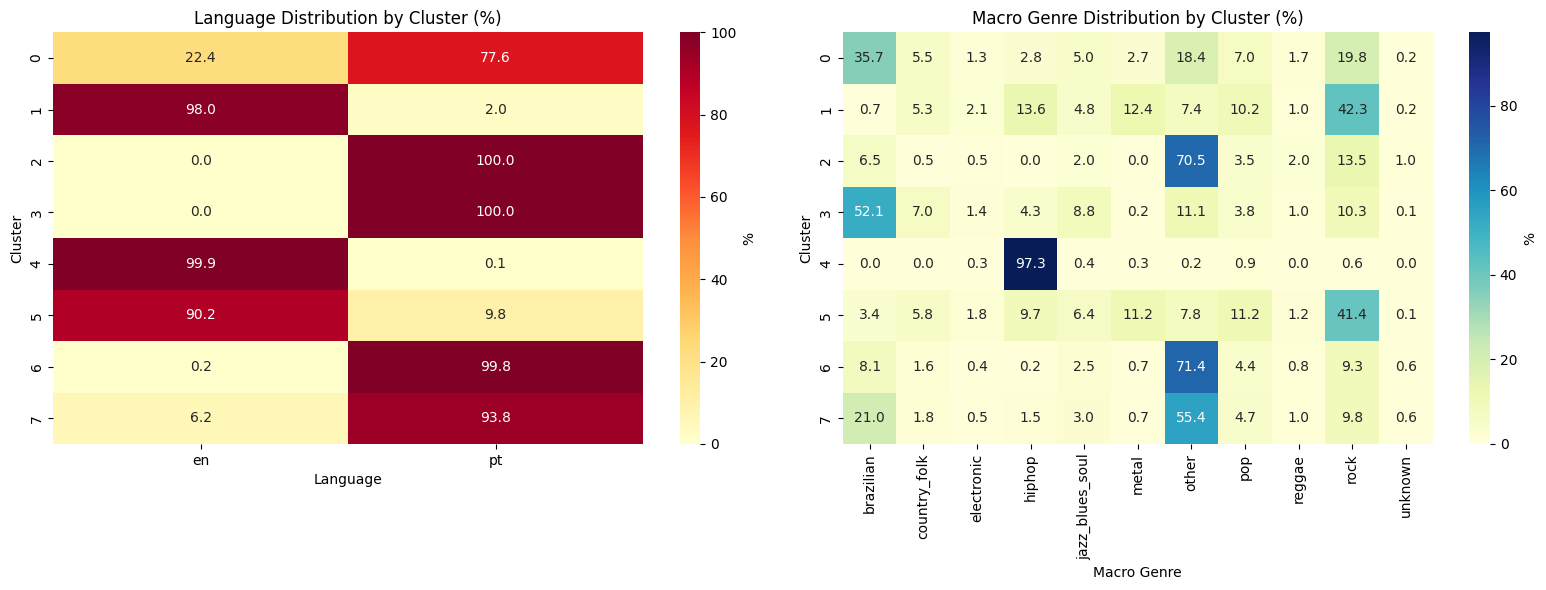

Saved distribution heatmaps to: /kaggle/working/cse425_outputs/distribution_heatmaps.png


In [18]:
# =============================================================================
# STEP 11: DISTRIBUTION ANALYSIS
# =============================================================================

print("=" * 80)
print("STEP 11: DISTRIBUTION ANALYSIS")
print("=" * 80)

def create_distribution_tables(
    df: pd.DataFrame,
    cluster_labels: np.ndarray,
    output_dir: str
) -> None:
    """
    Create distribution tables for language and genre per cluster.
    """
    df = df.copy()
    df['cluster'] = cluster_labels
    
    # Language distribution by cluster
    print("\nLanguage Distribution by Cluster (%):")
    lang_dist = pd.crosstab(df['cluster'], df['language'], normalize='index') * 100
    display(lang_dist.round(1))
    
    lang_dist_path = os.path.join(output_dir, "language_distribution_by_cluster.csv")
    lang_dist.to_csv(lang_dist_path)
    print(f"Saved to: {lang_dist_path}")
    
    # Genre distribution by cluster
    print("\nMacro Genre Distribution by Cluster (%):")
    genre_dist = pd.crosstab(df['cluster'], df['macro_genre'], normalize='index') * 100
    display(genre_dist.round(1))
    
    genre_dist_path = os.path.join(output_dir, "genre_distribution_by_cluster.csv")
    genre_dist.to_csv(genre_dist_path)
    print(f"Saved to: {genre_dist_path}")
    
    # Cluster sizes
    print("\nCluster Sizes:")
    cluster_sizes = df['cluster'].value_counts().sort_index()
    display(cluster_sizes)
    
    return lang_dist, genre_dist


# Create distribution tables using KMeans labels
lang_dist, genre_dist = create_distribution_tables(lyrics_with_genres, primary_labels, Config.OUTPUT_DIR)

# Create visualization heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Language heatmap
sns.heatmap(lang_dist, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0], cbar_kws={'label': '%'})
axes[0].set_title('Language Distribution by Cluster (%)')
axes[0].set_ylabel('Cluster')
axes[0].set_xlabel('Language')

# Genre heatmap
sns.heatmap(genre_dist, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1], cbar_kws={'label': '%'})
axes[1].set_title('Macro Genre Distribution by Cluster (%)')
axes[1].set_ylabel('Cluster')
axes[1].set_xlabel('Macro Genre')

plt.tight_layout()
dist_plot_path = os.path.join(Config.OUTPUT_DIR, "distribution_heatmaps.png")
plt.savefig(dist_plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved distribution heatmaps to: {dist_plot_path}")


In [19]:
# =============================================================================
# STEP 12: VISUALIZATION (t-SNE / UMAP)
# =============================================================================

print("=" * 80)
print("STEP 12: VISUALIZATION")
print("=" * 80)

# Sample for visualization if needed
if len(latent_Z) > Config.VIS_SAMPLE_SIZE:
    print(f"Sampling {Config.VIS_SAMPLE_SIZE} points for visualization...")
    vis_indices = np.random.choice(len(latent_Z), Config.VIS_SAMPLE_SIZE, replace=False)
    Z_vis = latent_Z[vis_indices]
    labels_vis = primary_labels[vis_indices]
    df_vis = lyrics_with_genres.iloc[vis_indices].reset_index(drop=True)
else:
    Z_vis = latent_Z
    labels_vis = primary_labels
    df_vis = lyrics_with_genres

# Apply t-SNE
print(f"Running t-SNE on {len(Z_vis)} samples...")
print(f"  Perplexity: {Config.TSNE_PERPLEXITY}")
print(f"  Iterations: {Config.TSNE_N_ITER}")

tsne = TSNE(
    n_components=2,
    perplexity=Config.TSNE_PERPLEXITY,
    n_iter=Config.TSNE_N_ITER,
    random_state=RANDOM_SEED,
    init='pca'
)
Z_tsne = tsne.fit_transform(Z_vis)
print("t-SNE complete!")

# Try UMAP if available
try:
    import umap
    print("\nRunning UMAP...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=RANDOM_SEED)
    Z_umap = reducer.fit_transform(Z_vis)
    has_umap = True
    print("UMAP complete!")
except ImportError:
    print("\nUMAP not available, using t-SNE only")
    has_umap = False
    Z_umap = None


STEP 12: VISUALIZATION
Sampling 5000 points for visualization...
Running t-SNE on 5000 samples...
  Perplexity: 30
  Iterations: 1000
t-SNE complete!


2026-01-07 13:09:44.431329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767791384.652320      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767791384.718957      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767791385.248110      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767791385.248194      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767791385.248197      55 computation_placer.cc:177] computation placer alr


Running UMAP...
UMAP complete!


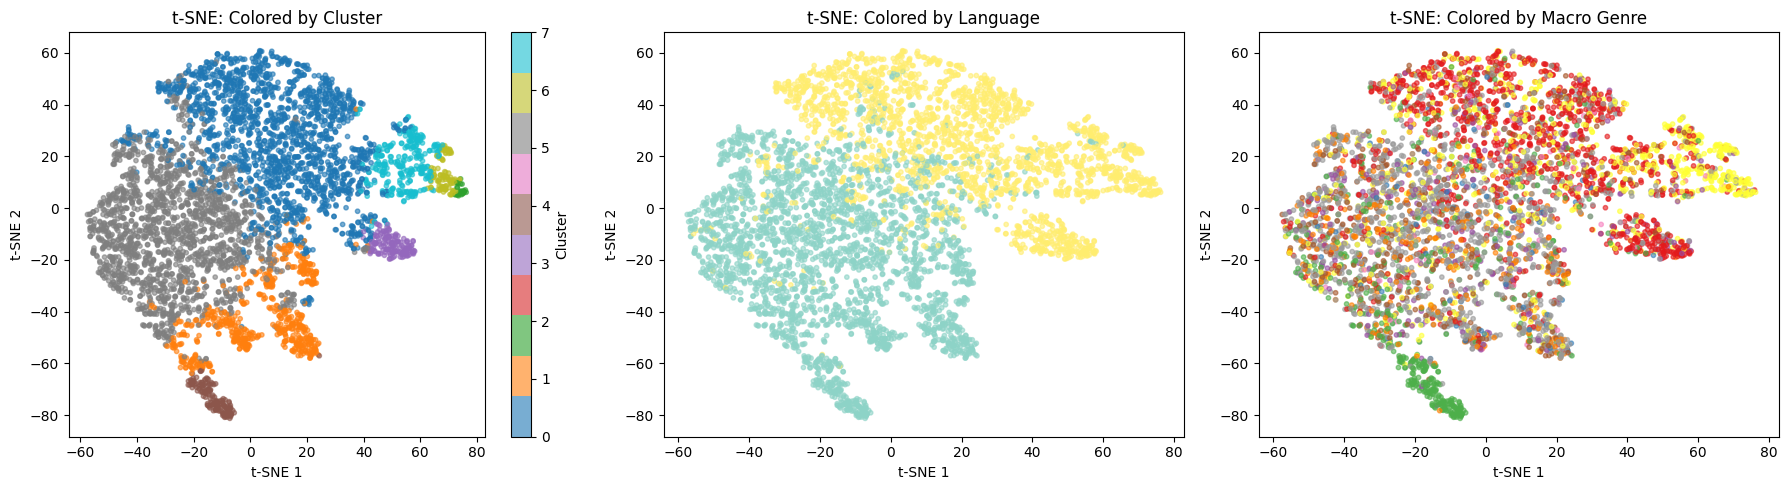

Saved t-SNE visualization to: /kaggle/working/cse425_outputs/tsne_visualization.png


In [20]:
# =============================================================================
# CREATE VISUALIZATION PLOTS
# =============================================================================

# Encode labels for coloring
lang_le = LabelEncoder()
lang_numeric = lang_le.fit_transform(df_vis['language'])

genre_le = LabelEncoder()
genre_numeric = genre_le.fit_transform(df_vis['macro_genre'])

# Main visualization: 3-panel t-SNE
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: t-SNE colored by cluster
scatter1 = axes[0].scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=labels_vis, cmap='tab10', alpha=0.6, s=10)
axes[0].set_title('t-SNE: Colored by Cluster')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: t-SNE colored by language
scatter2 = axes[1].scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=lang_numeric, cmap='Set3', alpha=0.6, s=10)
axes[1].set_title('t-SNE: Colored by Language')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')

# Plot 3: t-SNE colored by macro genre
scatter3 = axes[2].scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=genre_numeric, cmap='Set1', alpha=0.6, s=10)
axes[2].set_title('t-SNE: Colored by Macro Genre')
axes[2].set_xlabel('t-SNE 1')
axes[2].set_ylabel('t-SNE 2')

plt.tight_layout()
tsne_path = os.path.join(Config.OUTPUT_DIR, "tsne_visualization.png")
plt.savefig(tsne_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved t-SNE visualization to: {tsne_path}")


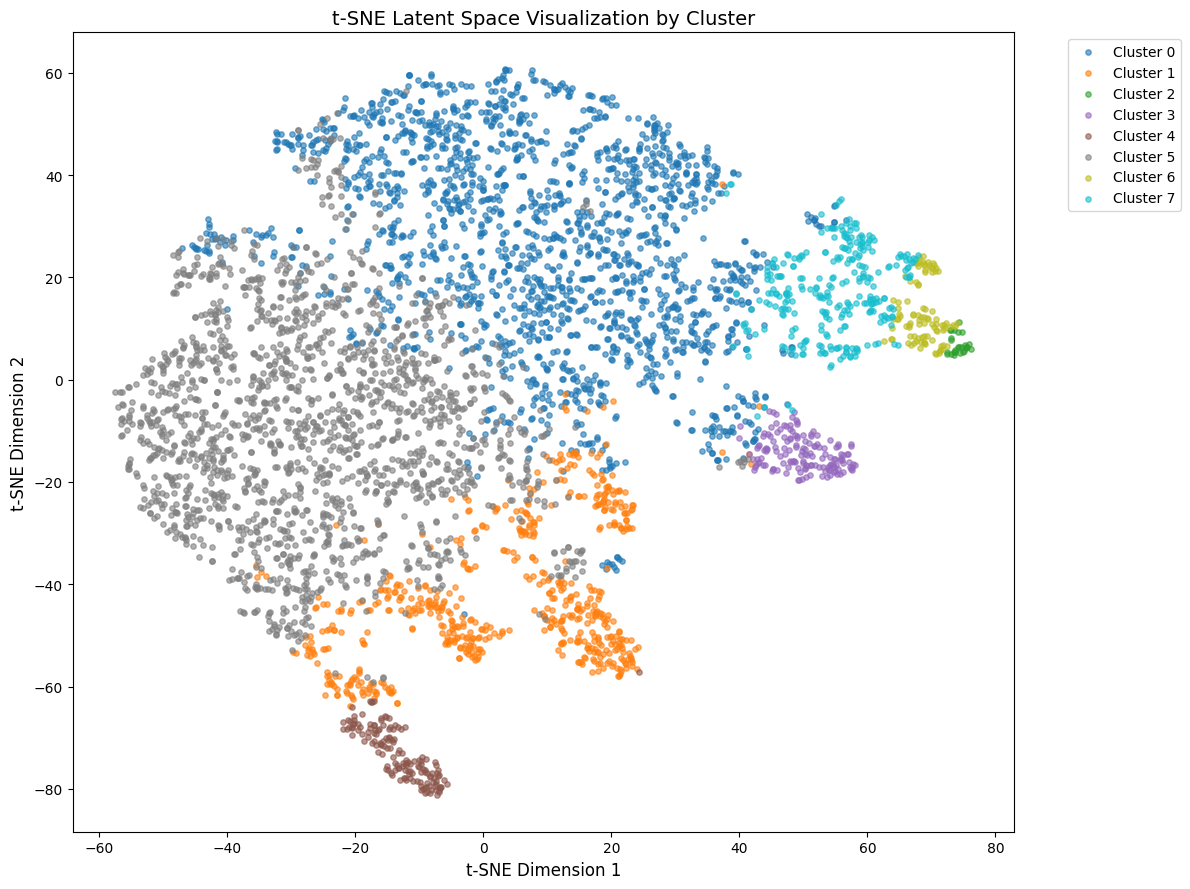

Saved cluster t-SNE to: /kaggle/working/cse425_outputs/tsne_by_cluster.png


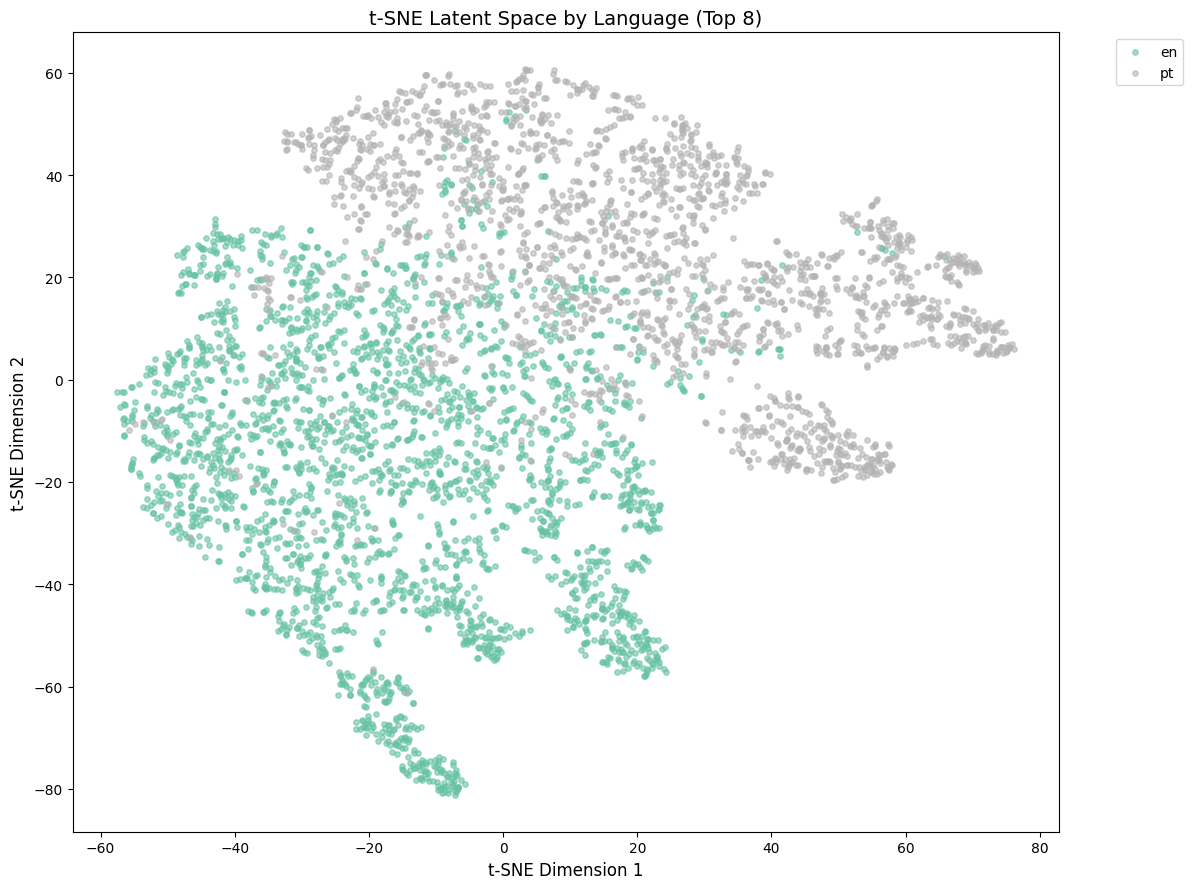

Saved language t-SNE to: /kaggle/working/cse425_outputs/tsne_by_language.png


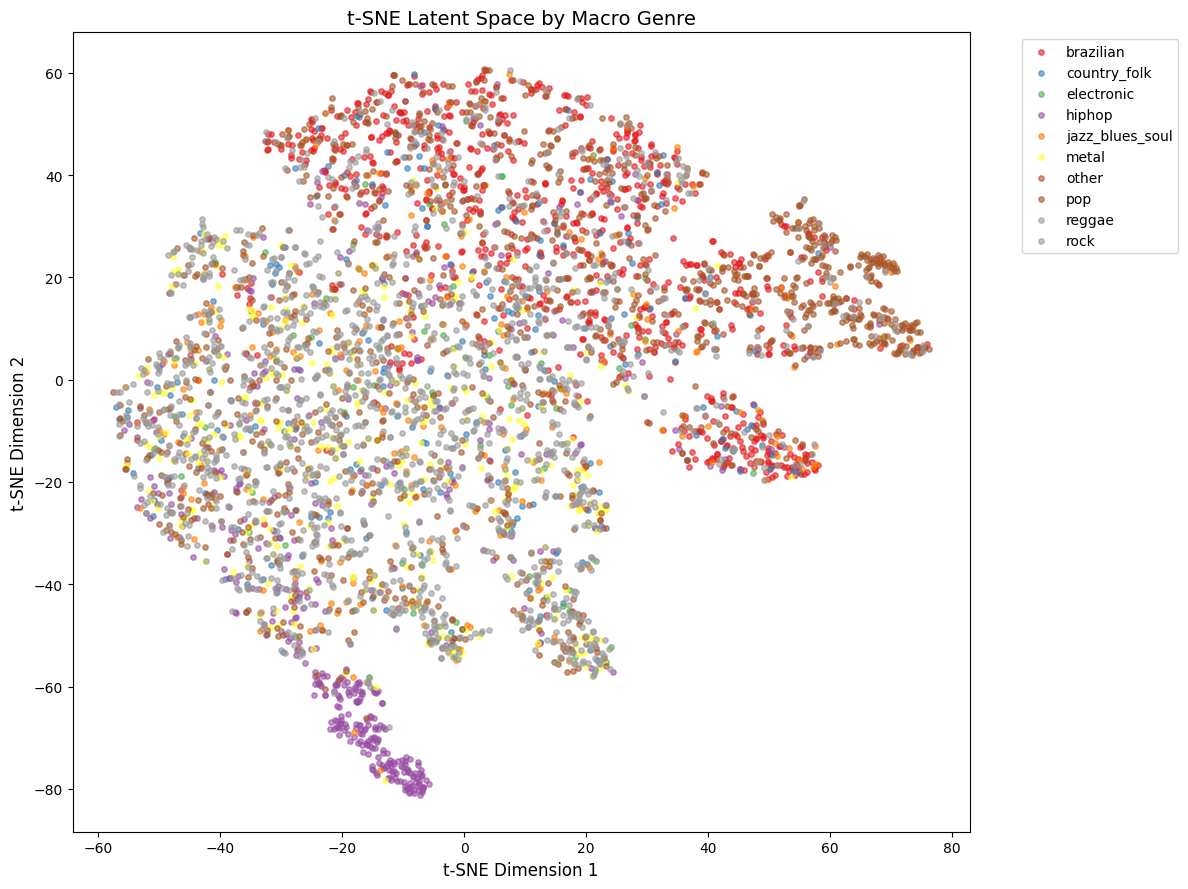

Saved genre t-SNE to: /kaggle/working/cse425_outputs/tsne_by_genre.png


In [21]:
# =============================================================================
# INDIVIDUAL HIGH-QUALITY PLOTS
# =============================================================================

# Cluster plot with legend
fig, ax = plt.subplots(figsize=(12, 9))
unique_clusters = sorted(set(labels_vis[labels_vis >= 0]))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

for i, cluster in enumerate(unique_clusters):
    mask = labels_vis == cluster
    ax.scatter(Z_tsne[mask, 0], Z_tsne[mask, 1], 
               c=[colors[i]], label=f'Cluster {cluster}', alpha=0.6, s=15)

ax.set_title('t-SNE Latent Space Visualization by Cluster', fontsize=14)
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
tsne_cluster_path = os.path.join(Config.OUTPUT_DIR, "tsne_by_cluster.png")
plt.savefig(tsne_cluster_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved cluster t-SNE to: {tsne_cluster_path}")

# Language plot (top 8 languages)
fig, ax = plt.subplots(figsize=(12, 9))
top_languages = df_vis['language'].value_counts().head(8).index
colors = plt.cm.Set2(np.linspace(0, 1, len(top_languages)))

for i, lang in enumerate(top_languages):
    mask = df_vis['language'] == lang
    ax.scatter(Z_tsne[mask.values, 0], Z_tsne[mask.values, 1],
               c=[colors[i]], label=lang, alpha=0.6, s=15)

ax.set_title('t-SNE Latent Space by Language (Top 8)', fontsize=14)
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
tsne_lang_path = os.path.join(Config.OUTPUT_DIR, "tsne_by_language.png")
plt.savefig(tsne_lang_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved language t-SNE to: {tsne_lang_path}")

# Genre plot
fig, ax = plt.subplots(figsize=(12, 9))
unique_genres = sorted([g for g in df_vis['macro_genre'].unique() if g != 'unknown'])
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_genres)))

for i, genre in enumerate(unique_genres):
    mask = df_vis['macro_genre'] == genre
    ax.scatter(Z_tsne[mask.values, 0], Z_tsne[mask.values, 1],
               c=[colors[i]], label=genre, alpha=0.6, s=15)

ax.set_title('t-SNE Latent Space by Macro Genre', fontsize=14)
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
tsne_genre_path = os.path.join(Config.OUTPUT_DIR, "tsne_by_genre.png")
plt.savefig(tsne_genre_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved genre t-SNE to: {tsne_genre_path}")


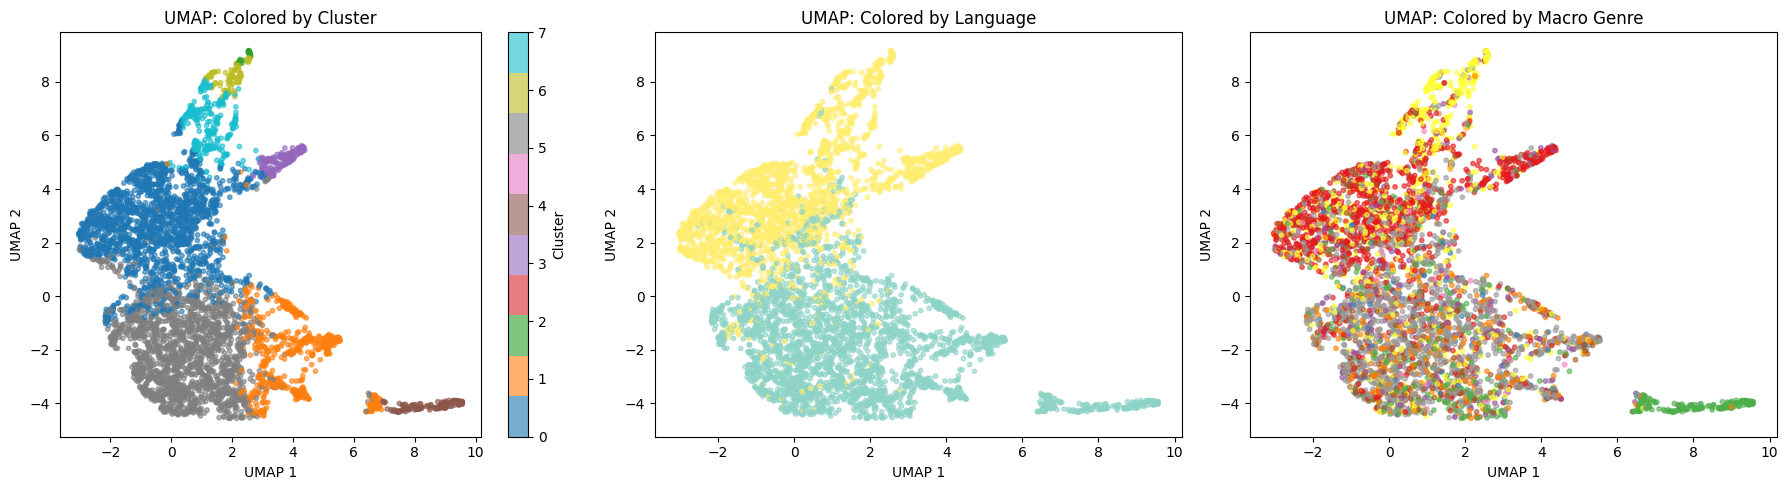

Saved UMAP visualization to: /kaggle/working/cse425_outputs/umap_visualization.png


In [22]:
# =============================================================================
# UMAP VISUALIZATION (if available)
# =============================================================================

if has_umap:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    scatter = axes[0].scatter(Z_umap[:, 0], Z_umap[:, 1], c=labels_vis, cmap='tab10', alpha=0.6, s=10)
    axes[0].set_title('UMAP: Colored by Cluster')
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    plt.colorbar(scatter, ax=axes[0], label='Cluster')
    
    scatter = axes[1].scatter(Z_umap[:, 0], Z_umap[:, 1], c=lang_numeric, cmap='Set3', alpha=0.6, s=10)
    axes[1].set_title('UMAP: Colored by Language')
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    
    scatter = axes[2].scatter(Z_umap[:, 0], Z_umap[:, 1], c=genre_numeric, cmap='Set1', alpha=0.6, s=10)
    axes[2].set_title('UMAP: Colored by Macro Genre')
    axes[2].set_xlabel('UMAP 1')
    axes[2].set_ylabel('UMAP 2')
    
    plt.tight_layout()
    umap_path = os.path.join(Config.OUTPUT_DIR, "umap_visualization.png")
    plt.savefig(umap_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved UMAP visualization to: {umap_path}")
else:
    print("UMAP visualization skipped (library not available)")


In [23]:
# =============================================================================
# STEP 13: CLUSTER INTERPRETATION
# =============================================================================

print("=" * 80)
print("STEP 13: CLUSTER INTERPRETATION")
print("=" * 80)

def interpret_clusters(
    df: pd.DataFrame,
    cluster_labels: np.ndarray,
    tfidf_vectorizer: TfidfVectorizer,
    output_dir: str,
    n_keywords: int = 15,
    n_examples: int = 5
) -> None:
    """
    Interpret each cluster by finding characteristic keywords and example songs.
    Uses TF-IDF difference from global mean to identify distinctive terms.
    """
    df = df.copy()
    df['cluster'] = cluster_labels
    
    # Get TF-IDF matrix for all lyrics
    print("Computing TF-IDF for cluster interpretation...")
    tfidf_matrix = tfidf_vectorizer.transform(df['cleaned_lyric'])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Global mean TF-IDF
    global_mean = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    
    cluster_keywords = {}
    cluster_examples = {}
    
    print("\n" + "=" * 70)
    print("CLUSTER INTERPRETATION")
    print("=" * 70)
    
    for cluster_id in sorted(df['cluster'].unique()):
        if cluster_id < 0:  # Skip noise
            continue
        
        cluster_mask = df['cluster'] == cluster_id
        cluster_size = cluster_mask.sum()
        
        print(f"\n{'=' * 70}")
        print(f"CLUSTER {cluster_id} ({cluster_size:,} songs)")
        print(f"{'=' * 70}")
        
        # Cluster mean TF-IDF
        cluster_tfidf = tfidf_matrix[cluster_mask.values]
        cluster_mean = np.asarray(cluster_tfidf.mean(axis=0)).flatten()
        
        # Difference from global mean (characteristic keywords)
        diff = cluster_mean - global_mean
        top_indices = diff.argsort()[-n_keywords:][::-1]
        
        keywords = [(feature_names[i], diff[i], cluster_mean[i]) for i in top_indices]
        cluster_keywords[cluster_id] = keywords
        
        print(f"\nTop Keywords (TF-IDF difference from global mean):")
        for word, diff_score, tfidf_score in keywords[:10]:
            print(f"  {word:25s} diff={diff_score:+.4f} tfidf={tfidf_score:.4f}")
        
        # Language breakdown
        lang_counts = df.loc[cluster_mask, 'language'].value_counts()
        print(f"\nLanguage Distribution:")
        for lang, count in lang_counts.head(5).items():
            print(f"  {lang}: {count} ({100*count/cluster_size:.1f}%)")
        
        # Genre breakdown
        genre_counts = df.loc[cluster_mask, 'macro_genre'].value_counts()
        print(f"\nGenre Distribution:")
        for genre, count in genre_counts.head(5).items():
            print(f"  {genre}: {count} ({100*count/cluster_size:.1f}%)")
        
        # Example songs
        examples = df.loc[cluster_mask, ['SName', 'language', 'macro_genre']].sample(
            n=min(n_examples, cluster_size),
            random_state=RANDOM_SEED
        )
        cluster_examples[cluster_id] = examples.values.tolist()
        
        print(f"\nExample Songs:")
        for _, row in examples.iterrows():
            song_name = str(row['SName'])[:50]
            print(f"  • {song_name:50s} [{row['language']}] [{row['macro_genre']}]")
    
    # Save cluster keywords
    keywords_data = []
    for cluster_id, keywords in cluster_keywords.items():
        for rank, (word, diff, tfidf) in enumerate(keywords, 1):
            keywords_data.append({
                'cluster': cluster_id,
                'rank': rank,
                'keyword': word,
                'tfidf_diff': diff,
                'tfidf_score': tfidf
            })
    
    keywords_df = pd.DataFrame(keywords_data)
    keywords_path = os.path.join(output_dir, "cluster_keywords.csv")
    keywords_df.to_csv(keywords_path, index=False)
    print(f"\nSaved cluster keywords to: {keywords_path}")
    
    # Save example songs
    examples_data = []
    for cluster_id, examples in cluster_examples.items():
        for song_name, lang, genre in examples:
            examples_data.append({
                'cluster': cluster_id,
                'song_name': song_name,
                'language': lang,
                'macro_genre': genre
            })
    
    examples_df = pd.DataFrame(examples_data)
    examples_path = os.path.join(output_dir, "cluster_examples.csv")
    examples_df.to_csv(examples_path, index=False)
    print(f"Saved cluster examples to: {examples_path}")


# Interpret clusters
interpret_clusters(
    lyrics_with_genres,
    primary_labels,
    tfidf_word,
    Config.OUTPUT_DIR
)


STEP 13: CLUSTER INTERPRETATION
Computing TF-IDF for cluster interpretation...

CLUSTER INTERPRETATION

CLUSTER 0 (15,286 songs)

Top Keywords (TF-IDF difference from global mean):
  que                       diff=+0.0302 tfidf=0.0670
  de                        diff=+0.0261 tfidf=0.0587
  eu                        diff=+0.0259 tfidf=0.0567
  não                       diff=+0.0247 tfidf=0.0532
  você                      diff=+0.0230 tfidf=0.0435
  pra                       diff=+0.0185 tfidf=0.0401
  um                        diff=+0.0173 tfidf=0.0376
  se                        diff=+0.0166 tfidf=0.0381
  amor                      diff=+0.0154 tfidf=0.0328
  meu                       diff=+0.0152 tfidf=0.0357

Language Distribution:
  pt: 11869 (77.6%)
  en: 3417 (22.4%)

Genre Distribution:
  brazilian: 5456 (35.7%)
  rock: 3025 (19.8%)
  other: 2809 (18.4%)
  pop: 1067 (7.0%)
  country_folk: 841 (5.5%)

Example Songs:
  • Gostoso Demais                                     [pt] [bra

In [24]:
# =============================================================================
# STEP 14: SAVE FINAL OUTPUTS
# =============================================================================

print("=" * 80)
print("STEP 14: SAVE FINAL OUTPUTS")
print("=" * 80)

# Add cluster assignments to dataframe
lyrics_with_clusters = lyrics_with_genres.copy()
lyrics_with_clusters['cluster_kmeans'] = clustering_results['kmeans'][0]
lyrics_with_clusters['cluster_agglomerative'] = clustering_results['agglomerative'][0]
lyrics_with_clusters['cluster_dbscan'] = clustering_results['dbscan'][0]
lyrics_with_clusters['cluster_baseline'] = baseline_labels

# Save cluster assignments
assignments_path = os.path.join(Config.OUTPUT_DIR, "cluster_assignments.csv")
lyrics_with_clusters.to_csv(assignments_path, index=False)
print(f"Saved cluster assignments to: {assignments_path}")

# Display sample assignments
print("\nSample Cluster Assignments:")
display(lyrics_with_clusters[['SName', 'language', 'macro_genre', 'cluster_kmeans', 'cluster_agglomerative']].head(10))


STEP 14: SAVE FINAL OUTPUTS
Saved cluster assignments to: /kaggle/working/cse425_outputs/cluster_assignments.csv

Sample Cluster Assignments:


,SName,language,macro_genre,cluster_kmeans,cluster_agglomerative
0,Radioactivity (mix Version),en,electronic,0,1
1,Maharaja Palace,en,metal,5,5
2,Son Of Hickory Holler's Tramp,en,country_folk,5,5
3,More Than This,en,rock,5,5
4,Radiant City,en,metal,5,5
5,Tropical Robots,en,other,0,5
6,Reggae Christmas (Ft. Paul Reubens),en,rock,1,0
7,Disease,en,metal,5,5
8,Freaks of Nature,en,rock,5,5
9,Sweet Road,en,other,5,5


In [27]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print(f"\nOutput directory: {Config.OUTPUT_DIR}")
print("\nSaved files:")

# List all saved files
saved_files = []
for root, dirs, files in os.walk(Config.OUTPUT_DIR):
    for file in sorted(files):
        filepath = os.path.join(root, file)
        size = os.path.getsize(filepath)
        saved_files.append((file, size))
        print(f"  • {file} ({size/1024:.1f} KB)")

print(f"\nTotal files saved: {len(saved_files)}")
print(f"Total size: {sum(s for _, s in saved_files)/1024/1024:.2f} MB")

# Summary statistics
print("\n" + "-" * 60)
print("EXPERIMENT SUMMARY")
print("-" * 60)

print(f"\nDataset:")
print(f"  Original lyrics: {len(lyrics_df):,}")
print(f"  After preprocessing: {len(lyrics_clean):,}")
print(f"  Sampled for analysis: {len(lyrics_sampled):,}")

print(f"\nFeatures:")
print(f"  TF-IDF dimensions: {Config.TFIDF_MAX_FEATURES_WORD + Config.TFIDF_MAX_FEATURES_CHAR}")
print(f"  SVD reduced to: {Config.SVD_COMPONENTS}")
print(f"  VAE latent dim: {Config.VAE_LATENT_DIM}")

print(f"\nClustering Results (VAE + KMeans):")
kmeans_metrics = clustering_results['kmeans'][1]
print(f"  N clusters: {Config.N_CLUSTERS}")
print(f"  Silhouette Score: {kmeans_metrics['silhouette']:.4f}")
print(f"  Calinski-Harabasz: {kmeans_metrics['calinski_harabasz']:.2f}")
print(f"  Davies-Bouldin: {kmeans_metrics['davies_bouldin']:.4f}")

print(f"\nPseudo-label Evaluation (vs Genre):")
kmeans_eval = [e for e in evaluation_results if 'kmeans' in e['method'].lower() and 'english' not in e['method'].lower()]
if kmeans_eval:
    print(f"  ARI: {kmeans_eval[0]['ari']:.4f}")
    print(f"  NMI: {kmeans_eval[0]['nmi']:.4f}")
    print(f"  Purity: {kmeans_eval[0]['purity']:.4f}")

print("\n" + "=" * 80)

print("=" * 80)
print(f"\nAll outputs saved to: {Config.OUTPUT_DIR}")



FINAL SUMMARY

Output directory: /kaggle/working/cse425_outputs

Saved files:
  • baseline_metrics.csv (0.1 KB)
  • cleaned_lyrics.csv (776809.1 KB)
  • cluster_assignments.csv (86473.7 KB)
  • cluster_examples.csv (1.2 KB)
  • cluster_keywords.csv (5.8 KB)
  • clustering_metrics.csv (0.5 KB)
  • distribution_heatmaps.png (147.1 KB)
  • genre_distribution_by_cluster.csv (1.5 KB)
  • language_distribution_by_cluster.csv (0.3 KB)
  • latent_vectors.npy (5000.1 KB)
  • pseudo_label_evaluation.csv (0.8 KB)
  • sampled_lyrics.csv (84348.8 KB)
  • training_curve.png (84.2 KB)
  • training_history.csv (7.7 KB)
  • tsne_by_cluster.png (582.5 KB)
  • tsne_by_genre.png (693.1 KB)
  • tsne_by_language.png (498.2 KB)
  • tsne_visualization.png (1076.4 KB)
  • umap_visualization.png (756.8 KB)
  • vae_model.pt (364.3 KB)

Total files saved: 20
Total size: 934.43 MB

------------------------------------------------------------
EXPERIMENT SUMMARY
------------------------------------------------------